In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from pandas_profiling import ProfileReport

In [2]:
df = sns.load_dataset('titanic')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
# profile = ProfileReport(df, title = 'Titanic')
# profile.to_file('Titanic.html')

In [46]:
categorical_features = df.select_dtypes(include = 'object').columns
numeric_features = df.select_dtypes(exclude = 'object').columns

In [7]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

<AxesSubplot:>

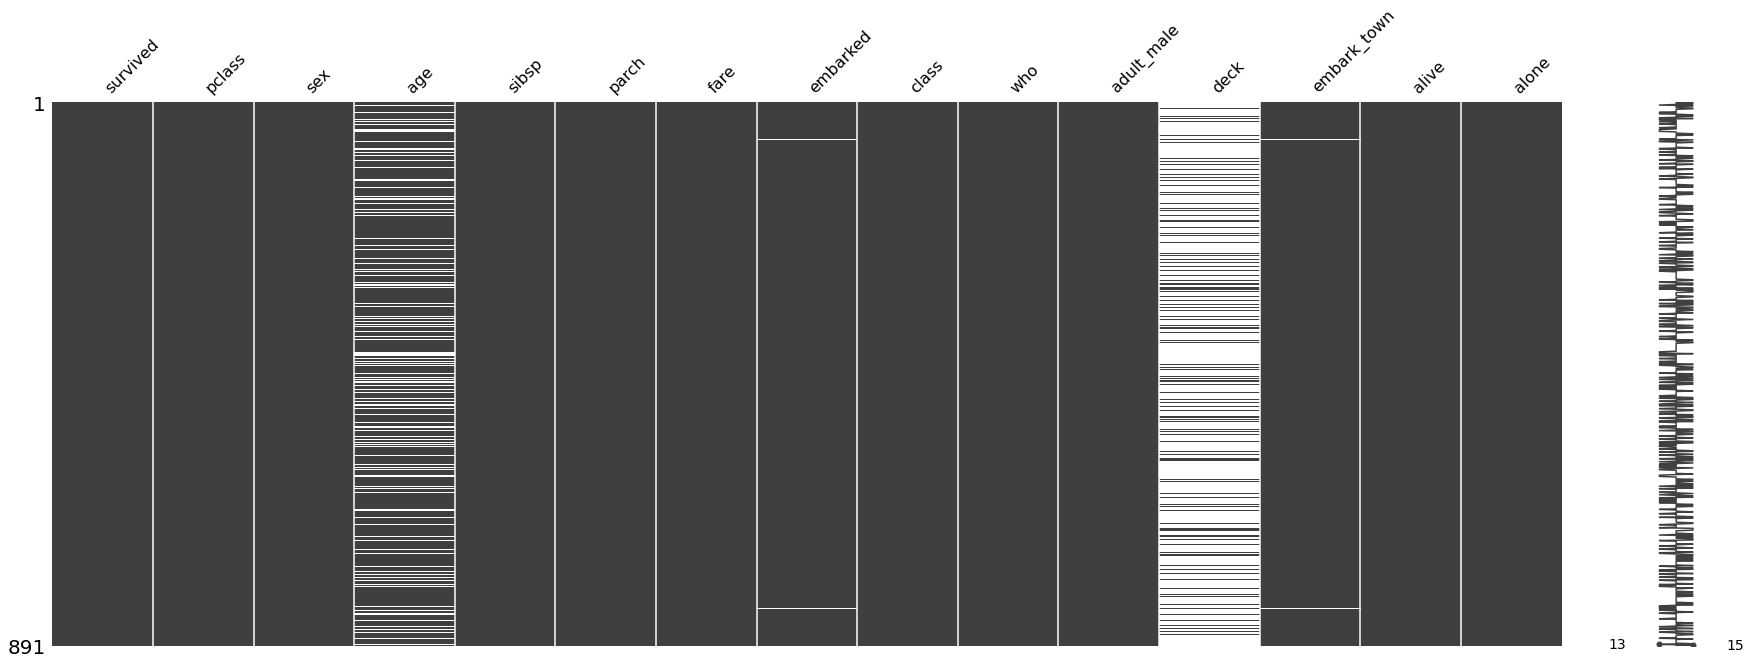

In [8]:
missingno.matrix(df, figsize = (30,10))

In [9]:
df = df.drop('deck', axis = 1)

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [39]:
df.dropna(subset = ['embarked', 'embark_town'], axis = 0, inplace = True)
df.drop(columns = ['sex'], axis = 1, inplace = True)

In [40]:
df.isnull().sum()

survived         0
pclass           0
age            177
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
embark_town      0
alive            0
alone            0
dtype: int64

<AxesSubplot:>

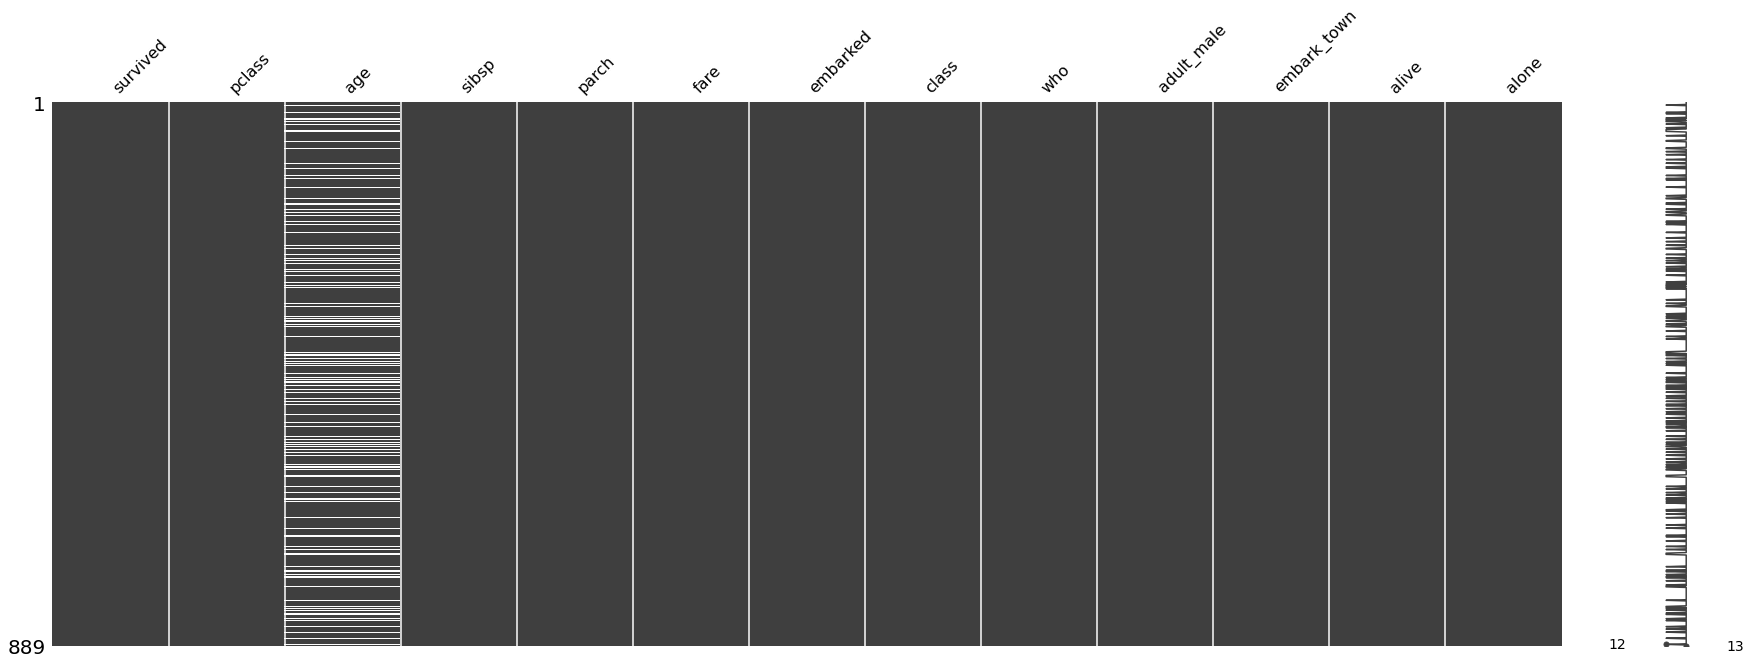

In [41]:
missingno.matrix(df, figsize = (30,10))

In [52]:
one_hot = ['who', 'adult_male', 'alone']
ordinal = ['embarked', 'class', 'embark_town']

In [93]:
ct = make_column_transformer(
    (OneHotEncoder(), one_hot),
    (OrdinalEncoder(), ordinal),
    (SimpleImputer(), ['age']),
    (StandardScaler(), ['pclass', 'sibsp', 'parch', 'fare', 'adult_male', 'alone']),
    remainder='drop'
)

In [94]:
ct

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['who', 'adult_male', 'alone']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['embarked', 'class', 'embark_town']),
                                ('simpleimputer', SimpleImputer(), ['age']),
                                ('standardscaler', StandardScaler(),
                                 ['pclass', 'sibsp', 'parch', 'fare',
                                  'adult_male', 'alone'])])

In [49]:
df.head()

,survived,pclass,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [59]:
X = df.drop('survived', axis = 1)
y = df['survived']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [117]:
pipelines = {
    'rf': make_pipeline(ct, RandomForestClassifier()),
    'gd': make_pipeline(ct, GradientBoostingClassifier()),
    'svc': make_pipeline(ct, SVC())
}

In [118]:
grid = {
    'rf': {
        'randomforestclassifier__n_estimators': [100, 500, 1000],
        'randomforestclassifier__max_depth': [5, 10, 20],
        'randomforestclassifier__min_samples_leaf': [1, 5, 10]
        },
    'gd': {
        'gradientboostingclassifier__learning_rate': [1, 0.1, 0.01],
        'gradientboostingclassifier__n_estimators': [100, 500, 1000],
        'gradientboostingclassifier__max_depth': [5, 10, 20]
    },
    'svc': {
        'svc__C': [2, 1, 0.1],
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'svc__cache_size': [100, 500, 1000]
    }
}

In [ ]:
SVC()

In [121]:
fit_models = {}
for algo, pipeline in pipelines.items():
    print(f'training the {algo} module')
    model = GridSearchCV(pipeline, grid[algo], n_jobs = -1, cv = 10)
    model.fit(X_train, y_train)
    fit_models[algo] = model

training the rf module
training the gd module
training the svc module


C:\Users\otbgo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.8185446  0.75528169 0.79467919 0.54282081        nan 0.8185446
 0.75528169 0.79467919 0.54282081        nan 0.8185446  0.75528169
 0.79467919 0.54282081        nan 0.8185446  0.71590376 0.79186228
 0.55123239        nan 0.8185446  0.71590376 0.79186228 0.55123239
        nan 0.8185446  0.71590376 0.79186228 0.55123239        nan
 0.8185446  0.6329421  0.61885759 0.61885759        nan 0.8185446
 0.6329421  0.61885759 0.61885759        nan 0.8185446  0.6329421
 0.61885759 0.61885759        nan]
  warnings.warn(


In [127]:
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [128]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    print(f'metrics for {algo} accuracy {acc}, precision {precision}, recall {recall}')

metrics for rf accuracy 0.7752808988764045, precision 0.704225352112676, recall 0.7246376811594203
metrics for gd accuracy 0.797752808988764, precision 0.726027397260274, recall 0.7681159420289855
metrics for svc accuracy 0.8146067415730337, precision 0.75, recall 0.782608695652174


In [129]:
df

,survived,pclass,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,S,Second,man,True,Southampton,no,True
887,1,1,19.0,0,0,30.0000,S,First,woman,False,Southampton,yes,True
888,0,3,NaN,1,2,23.4500,S,Third,woman,False,Southampton,no,False
889,1,1,26.0,0,0,30.0000,C,First,man,True,Cherbourg,yes,True
